In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

def train_episode(env, agent, max_steps=15000):
    done = False
    steps = 0
    episode_return = 0.0
    
    state = env.reset()
    action = agent.agent_start(state)

    while not done and steps<max_steps:
        steps += 1
        next_state, reward, done, _ = env.step(action)
        
        if (done==True):
            agent.agent_end(reward)
        else:
            action = agent.agent_step(reward, next_state)
            state = next_state

    return steps, episode_return, done

def train_episodes (env, agent, episodes):
    steps_per_episode = []
    episode_returns = []
    for episode in range(episodes):
        steps, episode_return, done = train_episode(env, agent)
        steps_per_episode.append(steps)
        episode_returns.append(episode_return)
    
    return steps_per_episode, episode_returns  

### Tile Coding

In [3]:
import tools.tiles3 as tc

class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8, position_range=1.8, velocity_range=.14):
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.position_scale = self.num_tiles / position_range
        self.velocity_scale = self.num_tiles / velocity_range
        
    def get_tiles(self, position, velocity):
        tiles = tc.tiles(self.iht, self.num_tilings, [position * self.position_scale, 
                                                      velocity * self.velocity_scale])
        
        return np.array(tiles)

In [4]:
class SarsaAgent:
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # We initialize self.mctc to the mountaincar verions of the 
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        ### START CODE HERE ###
        action_values = np.zeros(self.num_actions)
        for actionIx in range(self.num_actions):
            action_values[actionIx] = np.sum(self.w[actionIx][tiles])
        
        chosen_action = argmax(action_values)
        probs = np.ones(self.num_actions) * (self.epsilon / self.num_actions)
        probs [chosen_action] += 1-self.epsilon
        
        chosen_action = np.random.choice(self.num_actions, p=probs)
        ### END CODE HERE ###
        
        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, _ = self.select_action(active_tiles)
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, current_action_value = self.select_action(active_tiles)
        
        td_error = reward + self.gamma * current_action_value - np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * td_error
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.
        
        ### START CODE HERE ###
        td_error = reward - np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * td_error        
        ### END CODE HERE ###
        
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass
    
    def agent_policy(self, state):
        tiles = self.tc.get_tiles(position, velocity)
        action_values = np.zeros(self.num_actions)
        for actionIx in range(self.num_actions):
            action_values[actionIx] = np.sum(self.w[actionIx][tiles])
        
        chosen_action = argmax(action_values)
        return chosen_action

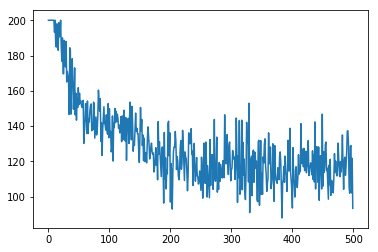

In [7]:
from envs.mountain_car_wrapper import MountainCarWrapper

num_runs = 5
num_episodes = 500
agent_info = {}
all_steps = []

env = gym.make('MountainCar-v0')
env = MountainCarWrapper(env)
agent_info = {"num_actions": env.action_space.n}

agent = SarsaAgent()

for run in range(num_runs):
    agent.agent_init(agent_info)
    steps_per_episode, episode_returns = train_episodes (env, agent, num_episodes)
    all_steps.append(np.array(steps_per_episode))

plt.plot(np.mean(np.array(all_steps), axis=0))

In [9]:
# Test Tile Coder
done = False
observation = env.reset()
episode_return = 0.0

while not done:
    position, velocity = observation
    action = agent.agent_policy(observation)
    next_observation, reward, done, _ = env.step(action)
    observation = next_observation
    episode_return += reward
    env.render()

print(episode_return)

-169.0


In [ ]:
# Simple policy (which is close to optimial) - just accelerate in the direction we were already moving.
done = False
observation = env.reset()
episode_return = 0.0

while not done:
    position, velocity = observation
    action = 0 if velocity<0 else 2
    next_observation, reward, done, _ = env.step(action)
    observation = next_observation
    episode_return += reward
    env.render()

print(episode_return)